In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.stats import ttest_rel
# from braindecode.datasets import MOABBDataset

from moabb.datasets import Wang2016

In [2]:
# dataset = MOABBDataset(dataset_name="Nakanishi2015", subject_ids=[1])

<!-- fname = C:\Users\Sunsun\mne_data\MNE-nakanishi-data\mnakanishi\12JFPM_SSVEP\raw\master\data\s1.mat -->

In [3]:
dataset = Wang2016()

subject =list(range(1,11))

dataset.subject_list = subject

In [4]:
dataset

In [5]:
sessions = dataset.get_data(subjects=subject)

Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data


In [6]:
session_name = "session_0"
run_name = "run_0"
raw_list = [sessions[id][session_name][run_name] for id in sessions]

raw = mne.concatenate_raws(raw_list)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


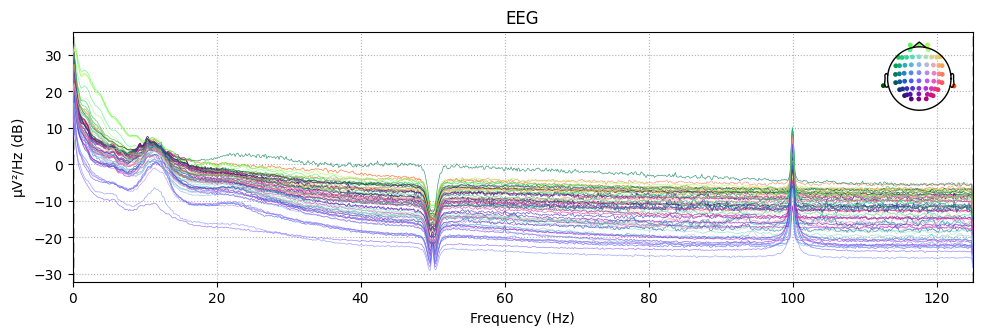

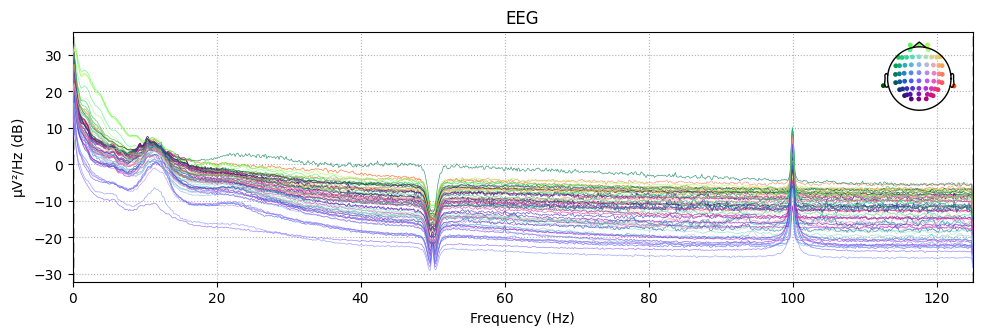

In [7]:
raw.plot_psd()

In [8]:
mne.find_events(raw)

2400 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


array([[     50,       0,       1],
       [   1650,       0,       1],
       [   3250,       0,       1],
       ...,
       [3835250,       0,      40],
       [3836850,       0,      40],
       [3838450,       0,      40]], dtype=int64)

In [9]:
# Load raw data
# data_path = mne.datasets.ssvep.data_path()
# data_path = moabb.datasets.Nakanishi2015.data_path(subject = 1)

# bids_fname = (data_path)

# raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)
raw.info['line_freq'] = 60.

# Set montage
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference('average', projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=1, h_freq=None, fir_design='firwin', verbose=False)

# Construct epochs
event_id = {
    '8hz': 1,
    '10hz': 3,
    '15hz': 8
}
# events, _ = mne.events_from_annotations(raw, verbose=False)
events = mne.find_events(raw)
tmin, tmax = 0., 5.  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,
    event_id=[event_id['8hz'], event_id['10hz'], event_id['15hz']], tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)

2400 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


In [10]:
tmin = 1.
tmax = 4.
fmin = 1.
fmax = 90.
sfreq = epochs.info['sfreq']

spectrum = epochs.compute_psd(
    'welch',
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)
psds, freqs = spectrum.get_data(return_freqs=True)

In [11]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise

In [12]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)

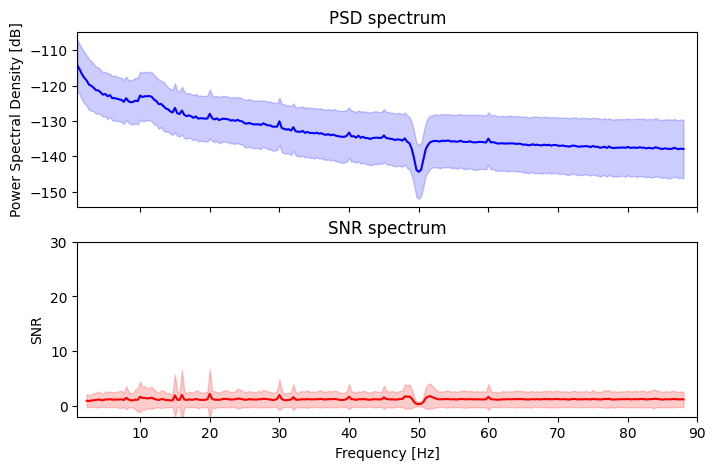

In [13]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig

In [14]:
# Define different ROIs
roi_vis = 'POZ', 'PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'O1', 'OZ'  # visual roi

# Find corresponding indices using mne.pick_types()
picks_roi_vis = mne.pick_types(epochs.info, eeg=True, stim=False,
                               exclude='bads', selection=roi_vis)

i_trial_8hz = np.where(epochs.events[:, 2] == event_id['8hz'])[0]
i_trial_10hz = np.where(epochs.events[:, 2] == event_id['10hz'])[0]
i_trial_15hz = np.where(epochs.events[:, 2] == event_id['15hz'])[0]

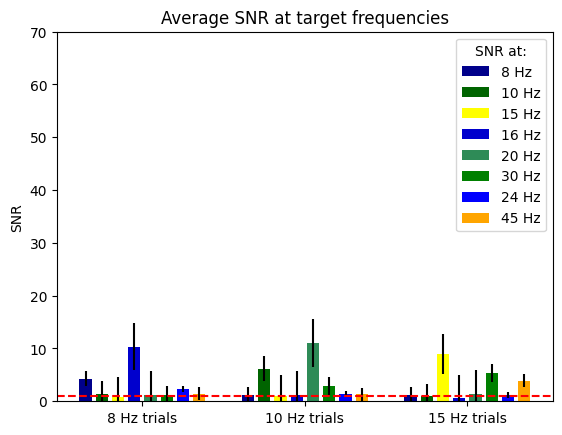

In [15]:
snrs_roi = snrs[:, picks_roi_vis, :].mean(axis=1)

freq_plot = [8, 10, 15, 16, 20, 30, 24, 45]
color_plot = [
    'darkblue', 'darkgreen', 'yellow', 'mediumblue',  'seagreen', 'green','blue', 'orange'
]
xpos_plot = [-7./12, -5. / 12, -3. / 12,  -1. / 12, 1. / 12,  3. / 12,  5. / 12, 7./12]
fig, ax = plt.subplots()
labels = ['8 Hz trials', '10 Hz trials', "15 Hz trials"]
x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
res = dict()

# loop to plot SNRs at stimulation frequencies and harmonics
for i, f in enumerate(freq_plot):
    # extract snrs
    stim_8hz_tmp = \
        snrs_roi[i_trial_8hz, np.argmin(abs(freqs - f))]
    stim_10hz_tmp = \
        snrs_roi[i_trial_10hz, np.argmin(abs(freqs - f))]
    stim_15hz_tmp = \
        snrs_roi[i_trial_15hz, np.argmin(abs(freqs - f))]
    SNR_tmp = [stim_8hz_tmp.mean(), stim_10hz_tmp.mean(), stim_15hz_tmp.mean()]
    # plot (with std)
    ax.bar(
        x + width * xpos_plot[i], SNR_tmp, width / len(freq_plot),
        yerr=np.std(SNR_tmp),
        label='%i Hz SNR' % f, color=color_plot[i])
    # store results for statistical comparison
    res['stim_6hz_snrs_%ihz' % f] = stim_8hz_tmp
    res['stim_10hz_snrs_%ihz' % f] = stim_10hz_tmp
    res['stim_15hz_snrs_%ihz' % f] = stim_15hz_tmp

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SNR')
ax.set_title('Average SNR at target frequencies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(['%i Hz' % f for f in freq_plot], title='SNR at:')
ax.set_ylim([0, 70])
ax.axhline(1, ls='--', c='r')
# fig.show()
fig

In [16]:
from mne import time_frequency

In [17]:
data = epochs.get_data()[:,:-1,:]
print(data.shape)

Using data from preloaded Raw for 180 events and 1251 original time points ...
(180, 64, 1251)


In [18]:
# Transforming the data using the Short Term Fourier Transform
stft_data = []
for i in range(data.shape[0]):
    stft = time_frequency.stft(data[i], wsize=252, verbose=False); 
    stft_data.append(np.expand_dims(stft, axis=0))
stft_data = np.concatenate(stft_data, axis=0)
stft_data.shape

(180, 64, 127, 10)

In [19]:
plt.rcParams["figure.figsize"] = [10,6]

In [20]:
picks_roi_vis

array([53, 54, 56, 57, 60])

In [21]:
i_trial_8hz = np.where(epochs.events[:, 2] == event_id['8hz'])[0]
i_trial_10hz = np.where(epochs.events[:, 2] == event_id['10hz'])[0]
i_trial_15hz = np.where(epochs.events[:, 2] == event_id['15hz'])[0]

(60, 64, 127, 10)
(45, 10)


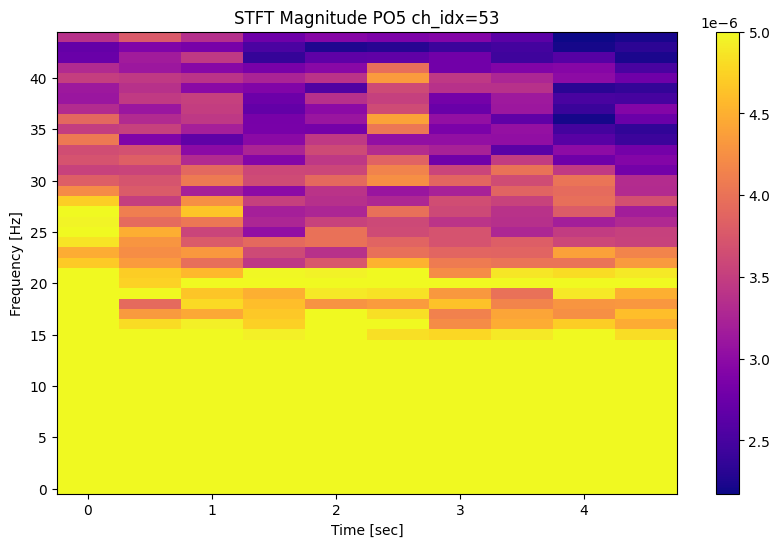

(60, 64, 127, 10)
(45, 10)


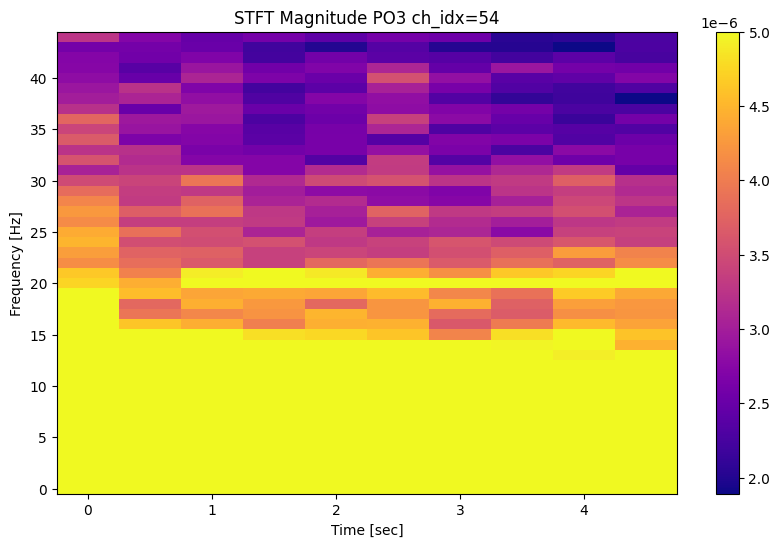

(60, 64, 127, 10)
(45, 10)


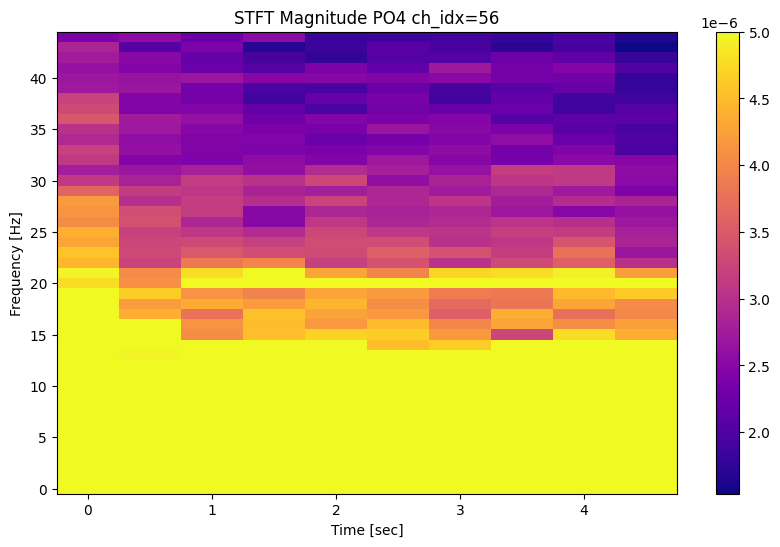

(60, 64, 127, 10)
(45, 10)


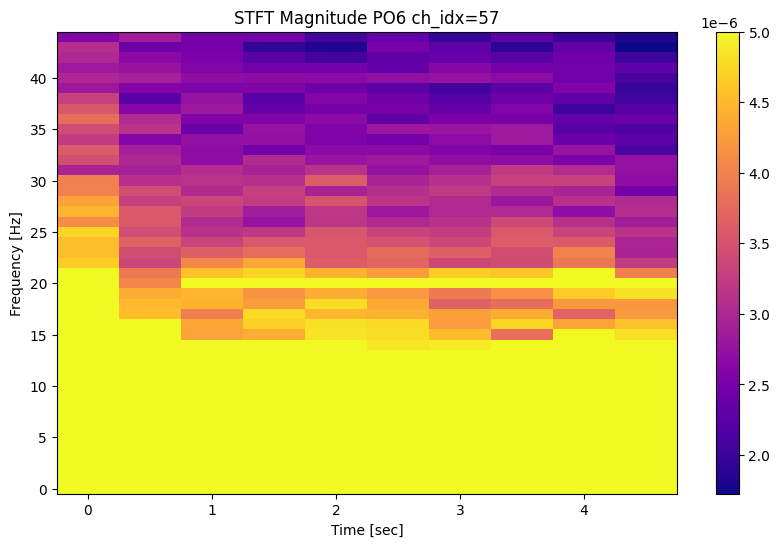

(60, 64, 127, 10)
(45, 10)


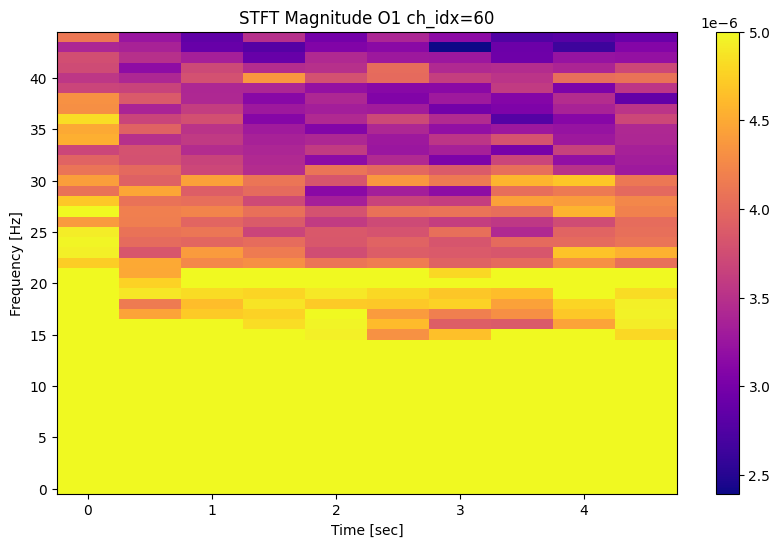

In [26]:
sample_idx = 4

for ch_idx in picks_roi_vis:
    X = stft_data[i_trial_10hz]
    print(X.shape)
    X = abs(X)
    X = X.mean(axis=0)
    X = X[ch_idx]
    X = X[:45,:]
    print(X.shape)

    c = plt.pcolormesh(np.arange(0,X.shape[1]//2,0.5), range(X.shape[0]), np.abs(X), cmap='plasma', vmax=5e-6)
    plt.colorbar(c)
    plt.title(f'STFT Magnitude {raw.ch_names[ch_idx]} {ch_idx=}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

In [23]:
viz_data = stft_data[2]
print(viz_data.shape)


(64, 127, 10)


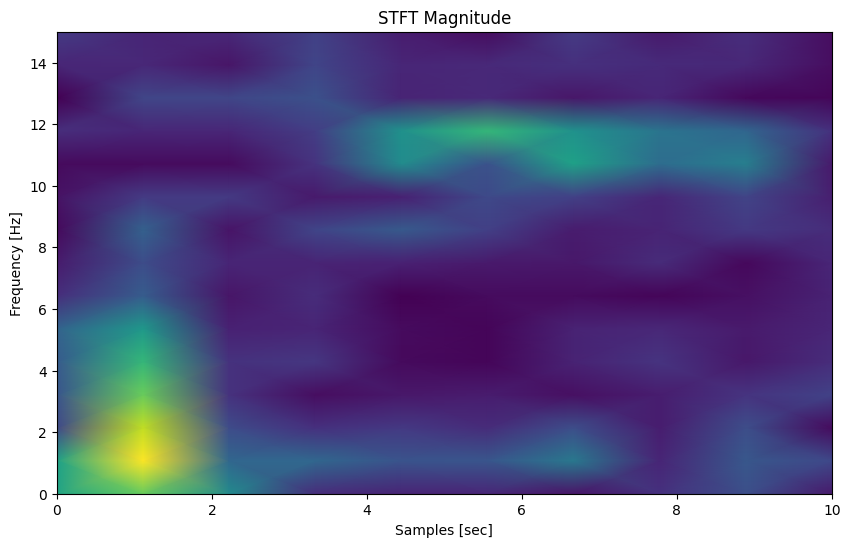

In [24]:
plt.pcolormesh(np.linspace(0,  viz_data.shape[2] , num= viz_data.shape[2]),# x
               np.linspace(0, 15 , num=15),# y
               np.abs(viz_data[62][:15,:]),
               shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples [sec]')
plt.show()

In [25]:
raw.ch_names

['Fp1',
 'Fpz',
 'Fp2',
 'AF3',
 'AF4',
 'F7',
 'F5',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'FC6',
 'FT8',
 'T7',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'M1',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'CP6',
 'TP8',
 'M2',
 'P7',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO7',
 'PO5',
 'PO3',
 'POz',
 'PO4',
 'PO6',
 'PO8',
 'CB1',
 'O1',
 'Oz',
 'O2',
 'CB2',
 'stim']